# Deep Learning course - LAB 6

## Images in Python and PyTorch - custom Datasets and DataLoaders

### Welcome to the fantastic world of Computer Vision!

This Lab will roughly be split in two logically-connected sections:

1. Image manipulation using OpenCV: we will have a quick tour of OpenCV Python API for image management and manipulation.
2. We will learn how to construct a custom Dataset in PyTorch (both in time-efficient and memory-efficient ways) and how to feed Datasets into DataLoaders for ANN training. Here, we will use the basics learned in Part 1 to construct specific data augmentation techniques.

## 1. Introduction to OpenCV

OpenCV is a library for real-time Computer Vision (CV) applications, originally developed by Intel, programmed in C++ and providing a useful Python wrapper.

It can be installed with pip with `pip install opencv-python`. Since the whole of the library has been recently rendered unusable due to trademark reasons (i.e., some of the algorithm implemented there were copyrighted and could not be freely used on OpenCV), there exists an extended version of OpenCV called `opencv-contrib-python` which re-implements these. We will be using the main library since we will not be needing those additional functionalities.

For the lab part, we will be needing a couple of additional libraries which you should install in order to execute the code on your machine:

- OpenCV: `pip install opencv-python`
- get_image_size: `pip install git+git://github.com/scardine/image_size`
- PIL: `pip install Pillow`

In [1]:
# to install get_image_size
# import sys
# !{sys.executable} -m pip install git+git://github.com/scardine/image_size

In [2]:
import torch
import cv2 #opencv
from matplotlib import pyplot as plt
import numpy as np
from get_image_size import get_image_size

### Image IO and basics

Load images into memory with `cv2.imread`

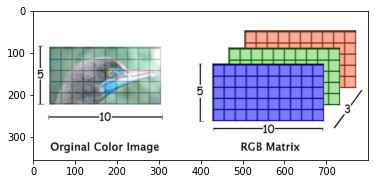

In [3]:
# read an image
img = cv2.imread("img/image_tensor.png")
# can show via matplotlib
plt.imshow(img)

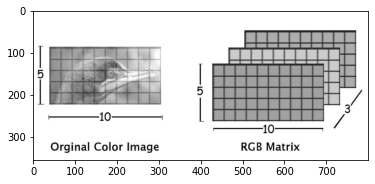

In [4]:
# read an image in grayscale -- notice the non-pythonic origin of CV2
img_bw = cv2.imread("img/image_tensor.png", flags=cv2.IMREAD_GRAYSCALE)
plt.imshow(img_bw, cmap="gray")

In [5]:
# be careful about nonexisting paths, as OpenCV does not check for existence
img_nonexist = cv2.imread("img/nonexisting_image.jpg")
type(img_nonexist)

NoneType

You might want to use a helper function for that (if efficiency is not your top priority)

In [6]:
def imread(path, **kwargs):
    img = cv2.imread(path, **kwargs)
    if img is None:
        raise RuntimeError(f"Nonexisting image at path {path}")
    return img

What is the type of the image?

In [7]:
type(img)

numpy.ndarray

OpenCV in Python treats the images as NumPy arrays. This means that we can use the extensive support of NumPy to elaborate them.

Image shape (356, 800, 3)


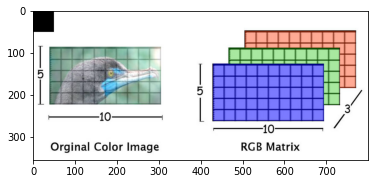

In [8]:
print("Image shape", img.shape)

## overlay a small box in the top-left part of the image
img[:50,:50] = np.array([0,0,0])
plt.imshow(img)

**Q**: By the way, did you notice something wrong with colors in the image above?

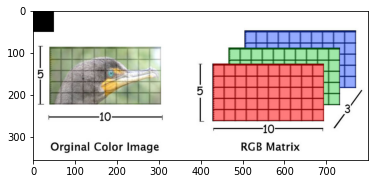

In [9]:
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)

Let us avoid future troubles by implementing another helper:

In [10]:
def implot(img):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

Grayscale images are just matrices

In [11]:
img_bw.shape

(356, 800)

We can even use NumPy to create some simple images

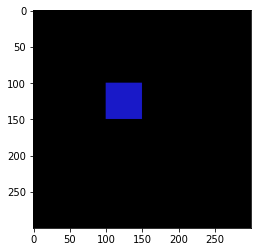

In [12]:
created_image = np.zeros((300, 300, 3), dtype="uint8") # notice the dtype!!
created_image[100:150, 100:150] = np.array([200, 25, 25], dtype="uint8")
implot(created_image)

Let us quickly go to more "advanced" stuff.

### Image resizing

Just use `cv2.resize`

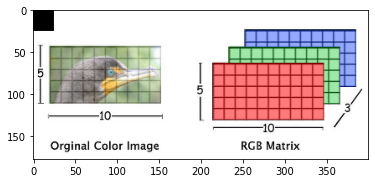

In [13]:
h, w = img.shape[:2]
resizing_factor = 0.5
new_h = int(h * resizing_factor)
new_w = int(w * resizing_factor)
# be careful at the order here, we have (WIDTH x HEIGHT)!!
img_res = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_LANCZOS4) # interpolation is necessary for both upscaling and downscaling
implot(img_res)

## Colorspaces

OpenCV offers support for a very large number of color spaces.

To convert images from a colorspace to another one, you need to use `cv2.cvtColor(image, flag)` where the flag usually goes by the name `cv2.COLOR_COLORSPACE2COLORSPACE`. For instance, if we wish to convert a BGR image to LAB, we just call

In [14]:
imglab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

Note: image plotting works only with RGB images. If we want to plot a LAB image, we must first convert it to RGB!

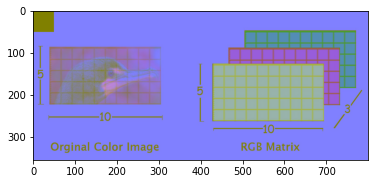

In [15]:
implot(imglab) # wrong!

## Overlay text and geometric shapes

Before we have seen an uncanny way to overlay a black rectangle onto the image using a simple NumPy array slicing.

There exist OpenCV built-in methods to overlay many kinds of geometric shapes, like circles, polygons, etc. and also text.

Inspired by [OpenCV docs tutorials](https://docs.opencv.org/master/dc/da5/tutorial_py_drawing_functions.html).

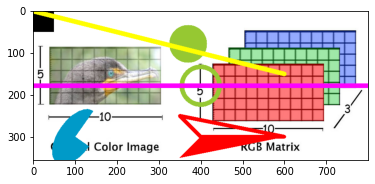

In [16]:
ctr_circle = (img.shape[1]//2, img.shape[0]//2)
cv2.circle(img, ctr_circle, radius=45, color=(50,200,150), thickness=10)

ctr_circle_solid = (ctr_circle[0]-30, ctr_circle[1]-100)
cv2.circle(img, ctr_circle_solid, radius=45, color=(50,200,150), thickness=-1) # thickness = - 1 means solid

ctr_ellipse = (100, 300)
cv2.ellipse(img, ctr_ellipse, (40, 75), angle=35, startAngle=0, endAngle=270, color=(200, 154, 0), thickness=-1)

points = np.array([[600, 300], [400, 300], [350, 350]], dtype="int32").reshape((-1, 1, 2))
cv2.fillPoly(img, pts=[points], color=(0,0,255))

points = np.array([[600, 300], [400, 300], [350, 250]], dtype="int32").reshape((-1, 1, 2))
cv2.polylines(img, isClosed=True, pts=[points], color=(0,0,255), thickness=8)

cv2.line(img, (0,0), (600, 150), (0, 255, 255), thickness=10)
cv2.line(img, (0,img.shape[0]//2), (img.shape[1], img.shape[0]//2), (255, 0, 255), thickness=10)
implot(img)

Let us mark what we just drew with text

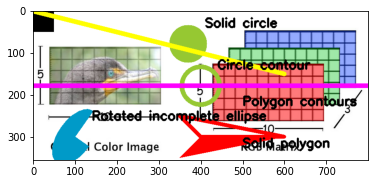

In [17]:
cv2.putText(img, "Circle contour", (ctr_circle[0] + 40, ctr_circle[1] - 40), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(0,0,0), thickness=3)
cv2.putText(img, "Solid circle", (ctr_circle_solid[0] + 40, ctr_circle_solid[1] - 40), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(0,0,0), thickness=3)
cv2.putText(img, "Rotated incomplete ellipse", (ctr_ellipse[0] + 40, ctr_ellipse[1] - 40), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(0,0,0), thickness=3)
cv2.putText(img, "Solid polygon", (500, 325), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(0,0,0), thickness=3)
cv2.putText(img, "Polygon contours", (500, 225), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(0,0,0), thickness=3)
implot(img)

## Convolution and filtering

OpenCV has some built-in functions for filtering. For example:

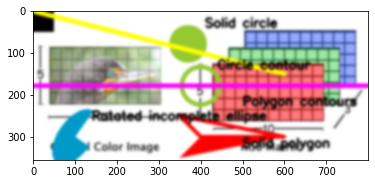

In [18]:
img_gauss = cv2.GaussianBlur(img, (0,0), 3) # image, kernel size ((0,0) means approxly infinite), sigma
implot(img_gauss)

Correlation is achieved via `cv2.filted2D`

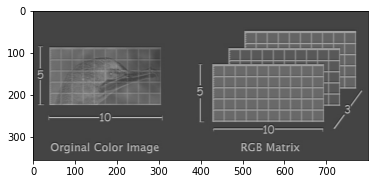

In [19]:
kernel = np.array([
    [-10, -10, -10],
    [0, 0, 0],
    [10, -10, 10]
], dtype="int32")
filtered = cv2.filter2D(img_bw, ddepth=cv2.CV_64F, kernel=kernel)
# rescale the image and convert it to uint8 precision
filtered -= filtered.min()
filtered *=  255 / filtered.max()
filtered = filtered.astype("uint8")
implot(filtered)

To obtain a "real" convolution, use [cv2.flip](https://docs.opencv.org/4.1.1/d2/de8/group__core__array.html#gaca7be533e3dac7feb70fc60635adf441)

# Dataset, DataLoader, and data augmentation

In this chapter, we will learn how to work with PT Datasets and DataLoaders.

In order to correctly execute the code below, you'll need to download the [DRIMDB dataset](https://units.sharepoint.com/sites/452SM-DEEPLEARNING2020/Documenti%20condivisi/General/Additional%20material%20for%20Labs/DRIMDB.rar).

Please extract the images into the "labs/datasets/DRIMDB" folder. The "datasets" folder should look like this:

![](img/path_folder.jpg)

#### Dataset description ([link](https://academictorrents.com/details/99811ba62918f8e73791d21be29dcc372d660305))

> Retinal image quality assessment (IQA) is a crucial process for automated retinal image analysis systems to obtain an accurate and successful diagnosis of retinal diseases. Consequently, the first step in a good retinal image analysis system is measuring the quality of the input image. \[...\] We used a three-class grading system that consists of **good, bad, and outlier classes**.

#### Sidenote

All of the images in the dataset have the same size, 570 $\times$ 760, besides a couple of exceptions. Since data wrangling is not the primary focus of the lecture, we're going to discard these images.

## Importing the dataset the time-efficient way

The time-efficient way to import a dataset in Python is by loading all the images into memory. Since our dataset is roughly ~35MB in size, it will not take away a significant chunk of RAM or GPU RAM.

A PyTorch dataset object inherits from `Dataset` and should have at least two methods implemented:
* the constructor, which should load the images (and the labels, if we're doing supervised learning) in memory
* a `__len__` method, which returns the number of images in the dataset
* a `__getitem__` method, which is used to access the image (and label) given its index

Let's implement it

In [20]:
import torch
import os
import cv2
import numpy as np
from torch.utils.data import Dataset
from matplotlib import pyplot as plt
import torchvision.transforms as T
from get_image_size import get_image_size
from PIL import Image
def implot(img):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [21]:
class DRIMDB_TimeEfficient(Dataset):
    def _read_images_and_labels_from_folder(self, folder, extension=".jpg"):
        if extension is None:
            extension = ""
        
        subfolders = [os.path.join(folder, f) for f in os.listdir(folder) if os.path.isdir(os.path.join(folder, f))]
        labels_list = []
        img_list = []

        for i, path in enumerate(subfolders):
            img_list_subfolder = [cv2.imread(os.path.join(path, f)) for f in os.listdir(path) if f.endswith(extension)]
            # discard images with shape different than 570x760
            img_list_subfolder = [img for img in img_list_subfolder if img.shape == (570, 760, 3)]
            img_list.extend(img_list_subfolder) # img_list = img_list + img_list_subfolder
            labels_list.extend([i] * len(img_list_subfolder))

        # Why arrays? You'll see later
        img_array = np.asarray(img_list) # 100 x 570 x 760 x 3
        labels_array = np.array(labels_list)
        
        return img_array, labels_array


    def __init__(self, root="datasets/DRIMDB", transform=None, **kwargs):
        self.data, self.targets = self._read_images_and_labels_from_folder(root, **kwargs) # note: these are the standard names for PT data and labels
        if transform is None:
            self.transform = lambda x: x
        else:
            self.transform = transform
    
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, index):
        return self.transform(self.data[index]), self.targets[index]


In [22]:
dataset = DRIMDB_TimeEfficient()
print(len(dataset))
entry_0 = dataset[0]
print(entry_0[0].shape, ",", entry_0[1])

213
(570, 760, 3) , 0


### Splitting a dataset in training set and test set

In [23]:
pct_trainset = .75
len_trainset = int(len(dataset) * pct_trainset)
len_testset = len(dataset) - len_trainset
trainset, testset = torch.utils.data.random_split(dataset, lengths=(len_trainset, len_testset))

### What do we need more than that?

We are almost ready to create the DataLoaders, which will then pass our data into the model.

One thing we need to do: a DataLoader needs to pass data to the network in form of torch tensors; preferably, the tensor should be centered on 0 for each of its channels (i.e., RGB for the images) to aid numerical calculations.

In PT, the info about how the DataLoader should handle the data is stored in the `transform` attribute of the dataset.

The `transform` attribute for images is usually a cascade (`torchvision.transforms.Compose`) of methods which apply sequentially to each of the image which the DataLoader samples in the current batch. It may be just an instruction on how to convert the data into tensors, but it may also contain optional data augmentation techniques. We'll quickly see the usual routine for tensor convertion.

In this case, the cascade is composed of:
* a conversion to tensor (`torchvision.transforms.ToTensor`) which converts the given array to a tensor and rescales it in the 0-1 range
* a normalization (`torchvision.transforms.Normalize`) such that the "images" have 0 mean and std of 1.

*Note: for dataset of natural images, especially if this dataset hardly fits in memory (think about ImageNet for a sec) in which case it's hard to get mean and std quickly, one can still normalize by considering channel-wise mean and std of 0.5. In our case, since the images have all similar colors with vary little variability, the results are widely different than 0.5.*

For the normalization, we first need the (rescaled) values of mean and std, which we can quickly recover:

In [24]:
for channel in (0,1,2):
    ch = dataset.data[:,:,channel] / 255
    print(channel, ch.mean(), ch.std())

0 0.1902312210610296 0.20566967825199337
1 0.19098244860363495 0.20601148050950963
2 0.19231765319586364 0.2063644428975245


Now that we have our values for means and std, we can apply this _minimal_ transformation pipeline to our datasets.

In [25]:
transform = T.Compose([
    T.ToTensor(),
    T.Normalize([0.190231, 0.190982, 0.192318], [0.205670, 0.206011, 0.206364])
])
trainset.transform = transform
testset.transform = transform

and we can create our DataLoaders, which we will then use to feed data and labels to the training routines.

Notice a couple of things:
* the batch_size for the training set is a hyperparameter. Too high of a batch size could mean that the optimizer goes straigth into a bad local optima. Too low and the optimizer could wander around aimlessly (i.e., the minibatch is too little representative of the dataset itself).
  * on the other hand, the batch_size for the test set is not a hyperparameter. we choose one which fits our RAM/GPU memory s.t. we can execute the calculation of the test statistics quickly but without overloading the memory itself.
* it is a good norm to reshuffle the batches (`shuffle` argument) after the conclusion of an epoch of training. However, doing it on the test set changes nothing in the calculation of the performance and only leads to slower computation.
* there's an additional keyword argument, `num_workers`, which specifies the number of processes working on the data loading task. If 0, a single process does all the job. This could result in a huge bottleneck as data loading (especially in the memory-efficient case we'll see after) may require a substantial amount of computation every time. If $n$, there'll be $n$ "slave" processes plus 1 "master" process loading the data.

In [26]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=8)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=8)

/home/angela/Documenti/Deep Learning/DSSC_DL_2021/venv/lib/python3.6/site-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## Importing the dataset the memory-efficient way

When a dataset is too large (think for a moment of ImageNet which weighs > 100Gb) you can't load it all into memory.
What we need to do is, instead, load the mini-batches in memory and keep the dataset on the disk.

We can accomplish that, for example, by storing a list of paths of the images in memory (which is most probably lighter than the images themselves) and by loading the images when `__getitem__` is called (which is what the DataLoader does). We trade off a bit of time efficiency for a better memory management.

In our implementation, we actually load directly the labels in RAM during the instantiation of the dataset. We could've also done this step inside `__getitem__`, as the images are loaded, with a bit more code.

In [27]:
class DRIMDB_MemoEfficient(Dataset):
    # now it loads targets + paths of images
    def _load_images_paths_and_labels(self, folder, extension=".jpg"):
        if extension is None:
            extension = ""

        subfolders = [os.path.join(folder, f) for f in os.listdir(folder) if os.path.isdir(os.path.join(folder, f))]
        img_path = []
        labels_list = []
        for i, path in enumerate(subfolders):
            img_path_subfolder = [os.path.join(path, f) for f in os.listdir(path) if f.endswith(extension) and get_image_size(os.path.join(path, f)) == (760, 570)]
            # note: the last check is to avoid loading a couple of "outlier" images which have wrong size
            img_path.extend(img_path_subfolder)
            labels_list.extend([i] * len(img_path_subfolder))
        
        return img_path, labels_list

    def __init__(self, root="datasets/DRIMDB", transform=None, **kwargs):
        self.data_paths, self.targets = self._load_images_paths_and_labels(root, **kwargs)
        if transform is None:
            self.transform = lambda x: x
        else:
            self.transform = transform
    
    def __len__(self):
        return len(self.data_paths)
    
    # __getitem__ now reads the image instead of just returning it
    def __getitem__(self, index):
        return self.transform(cv2.imread(self.data_paths[index])), self.targets[index]

Instantiate and analyze

In [28]:
dataset2 = DRIMDB_MemoEfficient()

In [29]:
print(dataset2.data_paths[17:25])
print(dataset2.targets[17:25])

['datasets/DRIMDB/Bad/drimdb_bad (52).jpg', 'datasets/DRIMDB/Bad/drimdb_bad (15).jpg', 'datasets/DRIMDB/Bad/drimdb_bad (3).jpg', 'datasets/DRIMDB/Bad/drimdb_bad (23).jpg', 'datasets/DRIMDB/Bad/drimdb_bad (19).jpg', 'datasets/DRIMDB/Bad/drimdb_bad (55).jpg', 'datasets/DRIMDB/Bad/drimdb_bad (44).jpg', 'datasets/DRIMDB/Bad/drimdb_bad (17).jpg']
[0, 0, 0, 0, 0, 0, 0, 0]


The `data_paths` in the dataset are strings.

In [30]:
sample = dataset2[17]
print(type(sample[0]), type(sample[1]))

<class 'numpy.ndarray'> <class 'int'>


...but if we call the `.__getitem__` method, we get an image (a NumPy array since we used cv2 to open it) and the category corresponding to that image.

We can now regularly feed the dataset to DataLoaders: this dataset has been created very quickly as we didn't need to open the images and allocate them inside a large array; on the other hand, the training will be slower since the images will be stored inside a (smaller) tensor at the time of the generation of the batches.

On to the **datasets transforms**:

Before, we called 
```python
transform = T.Compose([
    T.ToTensor(),
    T.Normalize([0.190231, 0.190982, 0.192318], [0.205670, 0.206011, 0.206364])
])
trainset.transform = transform
testset.transform = transform
```
1) Why is the output of the `__getitem__` still a NumPy array with values from 0 to 255 instead of a torch tensor with values around 0?

&nbsp;&nbsp;&nbsp;&nbsp;*It's your turn to answer...*

2) Why did we set the transform to `trainset` and `testset` separately? Couldn't we do it in the constructor of `dataset`?

&nbsp;&nbsp;&nbsp;&nbsp;The answer is **Data Augmentation**.

## Data Augmentation

Data Augmentation (DA) is a procedure through which we can artificially increase the size of our dataset in order to include data which is more representative of the data distribution $p(\mathcal{D})$, which is generally unknown, but might be (better) approximable by field knowledge or human common sense.

In addition to that, in case of images, it might require some proficiency in image elaboration.

The final aim of DA and in the enlargement of the dataset is to increase the generalization capability of the dataset. In fact, if the variability of the dataset is limited (i.e., $p(\mathcal{D})$ is badly represented by the training set), two things may usually happen:
* the network badly overfits on the training example and its test performance is trash
* the network goes into a state of *mode collapse*, i.e. it starts predicting always the same class (or better, it always remains in the neighborhood of the same prediction, to encompass also the regression case), completely ignoring the others.

Common DA techniques for images involve, for instance:
* random rotations or affine transformations (to approximate different PoVs of the oject)
* image flipping on the horizontal and/or vertical axis
* image cropping
* *deterioration* or *loss of detail* of parts of the image (to force the network to learn a different variety of features and not concentrate always on the same few ones -- this is a principle which has some ties to dropout)
* jittering (_modifications_) of the color of the image
* ...

of course, *common sense and field knowledge* are required when applying these transformations. For instance, if we work with MNIST and apply a random rotation from 0° to 360° to our images, we will quickly see that we might have done a bad mistake.

**Q**: why?

Color jittering is a bit more complicated, as it requires knowing what we are doing in terms of image processing. Think for a moment about applying it to natural images: what colors do we want to affect? by how much? Usually, when working with color jittering, it is a good practice to work with LAB/HSV images as color differences are more _humanly interpretable_ in these spaces than in RGB/BGR.

**Data augmentation is normally applied differently on train and test set. Usually you apply a *minimal* transform on test set (e.g., such that its domain is on the same level w.r.t. the train set), while more fancy transformations are applied to the train set only.** Of course, exceptions may apply.

### Torchvision built-in DA routines

The DA routines are stored in `torchvision.transform` (here called `T`).


A popular DA technique for natural images is inserting a small uni-color patch into the image to force the ANN to learn on the rest of the image itself.

Unfortunately, it's not comprised in the torchvision built-ins*. Let us implement it.

(*\* there is one (`RandomErasing`) which is a bit different than ours we'll be implementing below.*)

The DA technique is a `class` with a constructor and a `__call__` method. In the constructor we basically state all the _hyperparameters_ for the application of the technique; on the other hand, `__call__` receives only the image.

In [31]:
class RandomPatch():
    '''
    applies a patch of random size (in a specified interval) and a desided color with a desired probability value in a random position within the image.
    '''
    def __init__(self, max_h, max_w=None, min_h=None, min_w=None, p=1.0, color=(0,0,0)):
        assert p>=0.0 and p<=1.0, f"Probability of applying the patch is not in [0,1]. Found {p}."

        self.max_h = max_h
        self.max_w = max_w if max_w is not None else max_h
        self.min_h = min_h if min_h is not None else 0
        self.min_w = min_w if min_w is not None else 0
        self.p = p
        self.color = np.asarray(color)
    
    def __call__(self, img:np.ndarray):
        randunif = np.random.rand() # random uniform
        imgcopy = img.copy()
        if randunif <= self.p:
            h = np.random.randint(self.min_h, self.max_h + 1)
            w = np.random.randint(self.min_w, self.max_w + 1)
            # get top left corner of the patch ensuring that it'll fall within the image and not outside
            h_top = np.random.randint(0, img.shape[0] - h + 1)
            w_top = np.random.randint(0, img.shape[1] - w + 1)
            imgcopy[h_top : h_top + h, w_top : w_top + w] = self.color
        return imgcopy


Let us test if it works on one of our datasets:

In [32]:
randpatch = RandomPatch(40, 40, 40, 40)

our randpatch function will randomly draw (with probability 1) a black patch of fixed size 40px in a random location within the image

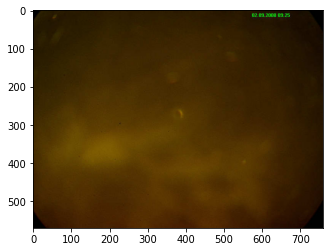

In [33]:
implot(dataset2[1][0])

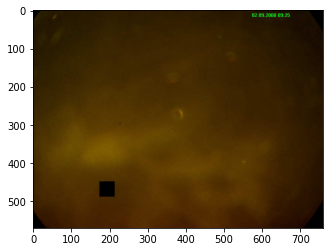

In [34]:
img_patch = randpatch(dataset2[1][0])
implot(img_patch)

#### Build a custom DA pipeline

In [35]:
class NP2PIL():
    def __call__(self, sample:np.ndarray):
        return Image.fromarray(cv2.cvtColor(sample, cv2.COLOR_BGR2RGB))

In [36]:
pipeline = T.Compose([
    randpatch,
    NP2PIL(), # Converts the image from numpy to Pillow (library used by pytorch for DA on images)
    T.RandomVerticalFlip(p=.75),
    T.RandomAffine(degrees=(-10, 10), translate=(.1,.1), scale=(.9, 1.15)),
])

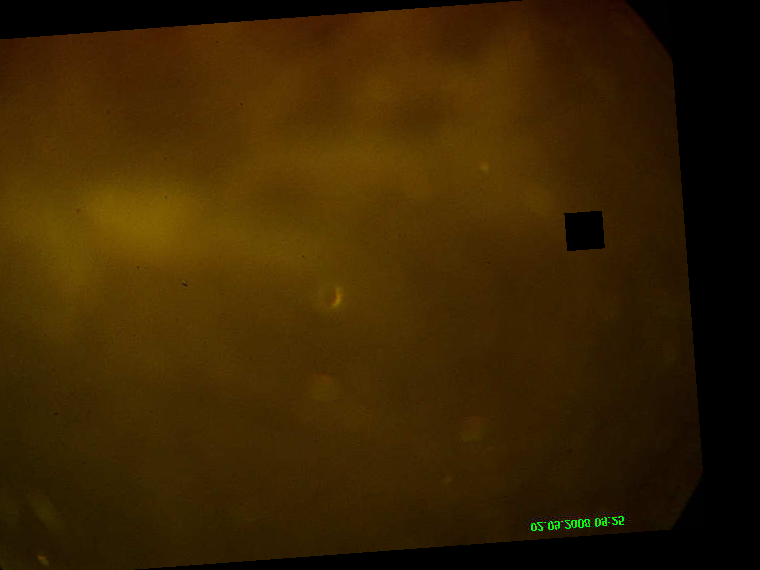

In [37]:
pipeline(dataset2[1][0])

We can set this pipeline on to a dataset to be passed on to the DataLoaders. First, though, we need to append one more transformation: `ToTensor()`, which converts the array or PIL Image to a tensor, changes its type to `float64` (required to train ANNs) then rescales it s.t. 255 → 1.

In [38]:
pipeline.transforms.append(T.ToTensor())

#### ! Bug on DataLoaders !

See [this](https://github.com/pytorch/pytorch/issues/5059) for more details.

Essentially, it concerns every DataLoader where:

1. we have more than 1 worker (→ `num_workers` > 0)
2. in the Dataset, we're using a NumPy RNG functionality (e.g. `np.random.rand`, `np.randint`...)

what happens is that, for each batch, the NumPy RNG will be reset to a fixed state, so the random functionality will not be random at all.

This is more of a problem on NumPy's side (it does not handle multiprocessing correctly...), but PyTorch offers a workaround in the form of a `worker_init_function`, which is a routine to customize the initialization of the subprocess. We can use it to randomly reset the NumPy RNG based on the current PyTorch random seed (which we know to be pseudo-random within the subprocess itself).

This is the most "elegant" solution, provided by the same developer of NumPy RNG functionalities:

In [39]:
def worker_init_function(proc_id):
    process_seed = torch.initial_seed()
    # Back out the base_seed so we can use all the bits.
    base_seed = process_seed - proc_id
    ss = np.random.SeedSequence([proc_id, base_seed])
    # More than 128 bits (4 32-bit words) would be overkill.
    np.random.seed(ss.generate_state(4))

In [40]:
dataset2.transform = pipeline

trainloader2 = torch.utils.data.DataLoader(dataset2, batch_size=32, shuffle=True, num_workers=4, worker_init_fn=worker_init_function)

In [41]:
X, y = next(iter(trainloader2))
print(X.shape, y.shape)

torch.Size([32, 3, 570, 760]) torch.Size([32])


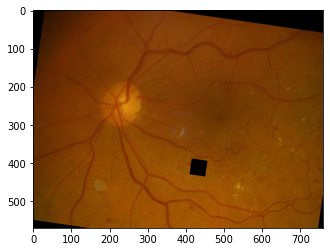

In [42]:
img = (X[0].permute(1,2,0)*255).numpy().astype("uint8") # -> convert tensor to cv2 image
plt.imshow(img)

Now, we're able to train our ANN. 🍾🎉

In [43]:
def worker_init_function(id):
    uint64_seed = torch.initial_seed()
    np.random.seed([uint64_seed >> 32, uint64_seed & 0xffff_ffff])

### Final remark - feeding images with different shape

While some Convolutional Neural Networks allow - in principle - to work with images of different size (namely, AllConvNets), it's extremely more efficient to feed data having the same shape.

The DataLoaders produce batches (for images) which are tensors of shape `batch_size x ch x h x w`, where `ch` is the number of color channels. It's hard (although possible) to fit images of different shape in this tensor.

One of the easiest solutions to implement a PyTorch Dataset for different-shaped images is to apply resizing to all images up to a common pre-established size. This may be a code snippet for the Dataset constructor:

```python
def __init__(self, ... , target_shape=(width, height)):
    [...]
    for img in images_list:
        img = cv2.resize(img, target_shape)
    self.data = np.asarray(images_list)
```

This solution may be inappropriate, though:

1. we first want to consider what are the **invariances** our classifier needs to have and not have. If the pictures are built such that the objects (which we call "Object A") to be recognized are **all at the same scale** (e.g., they're always of size 30x30 within the images, no matter the size of the image) by resizing these objects are likely gonna be of different sizes in the various images: an ANN trained on such images will likely develop a **scale invariance** and recognize the same object at different scales. But, is it what we want to achieve? Are there object of different classes which are similar to Object A's, but on different scale? In this case, the network may confuse these object with Object As. Consider that, **without data augmentations, Convolutional Neural Networks are only invariant to translation**.
2. an additional downside of rescaling to a fixed size, is that, by resizing, we might introduce fictitious/innatural aspect ratio of objects in our training set. Think about a circular object. In a very wide image, it might be squished to a very eccentric ellipse. By introducing innatural modifications, the ANN may learn more invariances than needed (and wrong features as well), and may actually performe worse on the test set.
3. finally, if the images vary widely in size, by rescaling to small sizes, some images may lose so much detail that the objects contained within may be borderline unrecongizable and the network may fail to learn significant feature for given categories.

In few words, resizing **is** a DA technique (as a matter of fact, you can find it in the torchvision transforms) and needs the same considerations as other DA 
techniques.

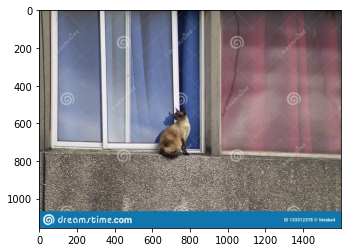

In [44]:
target_shape = (50, 50)
cat1 = cv2.imread("img/catfar.jpg")
implot(cat1)

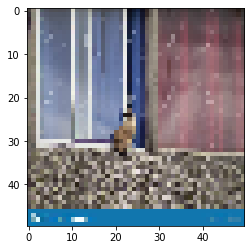

In [45]:
implot(cv2.resize(cat1, target_shape))

My advice on that is:

1. know your data (for images: shape, aspect ratio, detail...)
2. know your invariances
3. consider discarding some data, or cropping some images to be more centered w.r.t the object to classify, or in general to do some maintenance on the data to let it be more compliant w.r.t. your expectations;
  * you may even resort to operate an automatic **cropping** instead of reshaping to avoid ill effects of resizing, or a mix of both

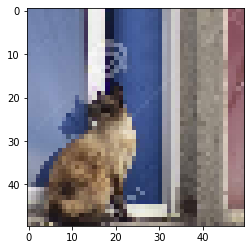

In [46]:
h, w = cat1.shape[:2]
hc = h//2
wc = w//2
implot(cv2.resize(cat1[hc-200:hc+200, wc-200:wc+200], target_shape)) # a vit better, isn't it?

Also, be very careful about the effects of **rotation** especially with oblong/ellipsoidal shaped objects:

![](https://pyimagesearch.com/wp-content/uploads/2016/12/opencv_rotate_round_pill_incorrect.gif)
![](https://pyimagesearch.com/wp-content/uploads/2016/12/opencv_rotate_oblong_pill_incorrect.gif)


[tutorial on that](https://www.pyimagesearch.com/2017/01/02/rotate-images-correctly-with-opencv-and-python/)

## References

### OpenCV

* [Official Py docs](https://docs.opencv.org/master/d6/d00/tutorial_py_root.html)

* [Learn OpenCV](https://learnopencv.com/) a site with extensive docs for practical application of OpenCV on the learning/recognition side.

### Custom Datasets and Dataloaders

* [Official PyTorch tutorial](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html) with extension to something more saucy than image classification. Here you also have the problem of determining a pose of the object within the image, hence the Dataset needs to return a bit more info.

* [PyTorch docs on transforms](https://pytorch.org/vision/stable/transforms.html)